In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
import os
import time
import random
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import pickle
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import matplotlib.pyplot as plt
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

import pickle

seed =1
torch.manual_seed(seed)
import cv2

from torchvision import transforms, utils
import torchvision.models as models
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
from multi_center_tools.multi_tools import open_pickle, select_df,load_TCGA_arrays,translate_mask, imshow
from multi_center_tools.ViT_tools import get_ViT_series,get_center_indexes,VitTCGAToTensor, Vit_TCGA_Dataset, Vit_JC_Dataset,VitJCToTensor
import copy
import copy
from torchmetrics import F1Score
f1ig0 = F1Score(num_classes=2, average='macro', ignore_index=0)
f1ig1 = F1Score(num_classes=2, average='macro', ignore_index=1)
import timm
from multi_center_tools.ViT_tools import extract, GetAttentionWeights, get_joint_aug_attentions, imshow_vit, get_vit_small_patch16_22_attention_mask, get_vit_small_patch16_22_attentions
IDH_dict={0:'IDH wild type', 1:'IDH 1 or 2 mutation'}

# tools

In [2]:
csv_loc = './All_japan.csv'
img_loc = './JC_array/'
TCGA_img_loc = './FR_BraTS2019_array/'

train_list = open_pickle(
    './ALL_Japan_train.pickle')
train_list = [int(n) for n in train_list]

val_list = open_pickle(
    './JC_Res34_tr_e16_val.pickle')
val_list = [int(n) for n in val_list]

test_list = open_pickle(
    './ALL_Japan_test.pickle')
test_list = [int(n) for n in test_list]

df =pd.read_csv(csv_loc)
train_pd = select_df(df,'ID',train_list )
test_pd = select_df(df,'ID',test_list )
val_pd = select_df(df,'ID',val_list )

#reset index
train_pd =train_pd.reset_index()
val_pd = val_pd.reset_index()
test_pd = test_pd.reset_index()

# ID int64  to str
train_pd['ID'] = [str(i )for i in train_pd['ID']]
val_pd['ID'] = [str(i )for i in val_pd['ID']]
test_pd['ID'] = [str(i )for i in test_pd['ID']]


TCGA_csv_loc = './TCGA_training_nondu.csv'
TCGA_train_list = open_pickle(
    './TCGA_Res34_tr_e29_train.pickle')

TCGA_val_list = open_pickle(
    './TCGA_Res34_tr_e29_val.pickle')

TCGA_df =pd.read_csv(TCGA_csv_loc)
TCGA_train_pd = select_df(TCGA_df,'BraTS_2019_subject_ID',TCGA_train_list )
TCGA_val_pd = select_df(TCGA_df,'BraTS_2019_subject_ID',TCGA_val_list )


#reset index
TCGA_train_pd =TCGA_train_pd.reset_index()
TCGA_val_pd = TCGA_val_pd.reset_index()


# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/"
if not os.path.exists(CHECKPOINT_PATH):
    os.makedirs(CHECKPOINT_PATH)
pretrained_filename ='./models/vit/epoch=3-step=64.ckpt'
save_name='ResNet_TCGA_CycleLR'

Z_score = False
SZ = True
Double = False
inst = None

Batch_size = 32
weights = torch.tensor([1.0, 1.0]).to(device)
epoch = 100
lr = 5e-3

mask = False
channel = 4

## Use only Center

In [ ]:
train_pd['tumor_index'] = get_center_indexes(train_pd, img_loc,ID_name="ID", JCT2=True)
v_train_pd = pd.DataFrame(get_ViT_series(train_pd, _width=0))
v_train_pd.reset_index()

val_pd['tumor_index'] = get_center_indexes(val_pd, img_loc,ID_name="ID", JCT2=True)
v_val_pd = pd.DataFrame(get_ViT_series(val_pd, _width=0))
v_val_pd.reset_index()

test_pd['tumor_index'] = get_center_indexes(test_pd, img_loc,ID_name="ID", JCT2=True)
v_test_pd = pd.DataFrame(get_ViT_series(test_pd, _width=0))
v_test_pd.reset_index()


In [13]:
s_train = Vit_JC_Dataset(v_train_pd, img_loc,z_score=Z_score,inst=inst, sz=SZ,
                                              double=Double, transform=VitJCToTensor())

In [14]:
s_train = Vit_JC_Dataset(v_train_pd, img_loc,z_score=Z_score,inst=inst, sz=SZ,inclued_mask=mask,
                                              double=Double, transform=VitJCToTensor())
s_val = Vit_JC_Dataset(v_val_pd, img_loc,z_score=Z_score,inst=inst, sz=SZ,inclued_mask=mask,
                                              double=Double, transform=VitJCToTensor())
s_test = Vit_JC_Dataset(v_test_pd, img_loc,z_score=Z_score,inst=inst, sz=SZ,inclued_mask=mask,
                                              double=Double, transform=VitJCToTensor())

train_loader = torch.utils.data.DataLoader(s_train, batch_size=Batch_size, shuffle=False, num_workers=0)
val_loader = torch.utils.data.DataLoader(s_val, batch_size=Batch_size, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(s_test, batch_size=Batch_size, shuffle = False, num_workers=0)

In [ ]:
TCGA_train_pd['tumor_index'] = get_center_indexes(TCGA_train_pd, TCGA_img_loc)
v_TCGA_train_pd = pd.DataFrame(get_ViT_series(TCGA_train_pd, _width=0))
v_TCGA_train_pd.reset_index()

TCGA_val_pd['tumor_index'] = get_center_indexes(TCGA_val_pd, TCGA_img_loc)
v_TCGA_val_pd = pd.DataFrame(get_ViT_series(TCGA_val_pd, _width=0))
v_TCGA_val_pd.reset_index()

In [16]:
TCGA_train =  Vit_TCGA_Dataset(v_TCGA_train_pd, TCGA_img_loc, z_score=Z_score,sz=SZ, double=Double,inst=inst,inclued_mask=mask,
                                                transform = VitTCGAToTensor())
TCGA_val =Vit_TCGA_Dataset(v_TCGA_val_pd, TCGA_img_loc, z_score=Z_score,sz=SZ, double=Double,inst=inst,inclued_mask=mask,
                                                transform = VitTCGAToTensor())

TCGA_train_loader = torch.utils.data.DataLoader(TCGA_train, batch_size=Batch_size, shuffle=False, num_workers=0)
TCGA_val_loader = torch.utils.data.DataLoader(TCGA_val, batch_size=Batch_size, shuffle = False, num_workers=0)

# Moodel

In [8]:
target_image = s_test[0][0]

In [9]:
#timm_model = model.model
#torch.save(model.model.state_dict(), 'bs32_normal_list1_fold0.pth')
timm_model = timm.create_model('vit_small_patch16_224', pretrained=True, in_chans=channel,num_classes=2 )
timm_model.load_state_dict(torch.load('./dev/bs32_normal_list1_fold0.pth'))

<All keys matched successfully>

In [10]:
mask = get_vit_small_patch16_22_attention_mask(timm_model,target_image)

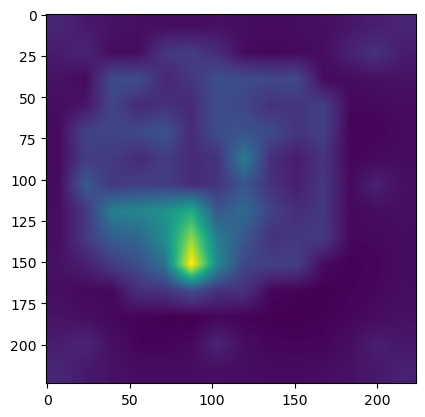

In [11]:
plt.imshow(mask)

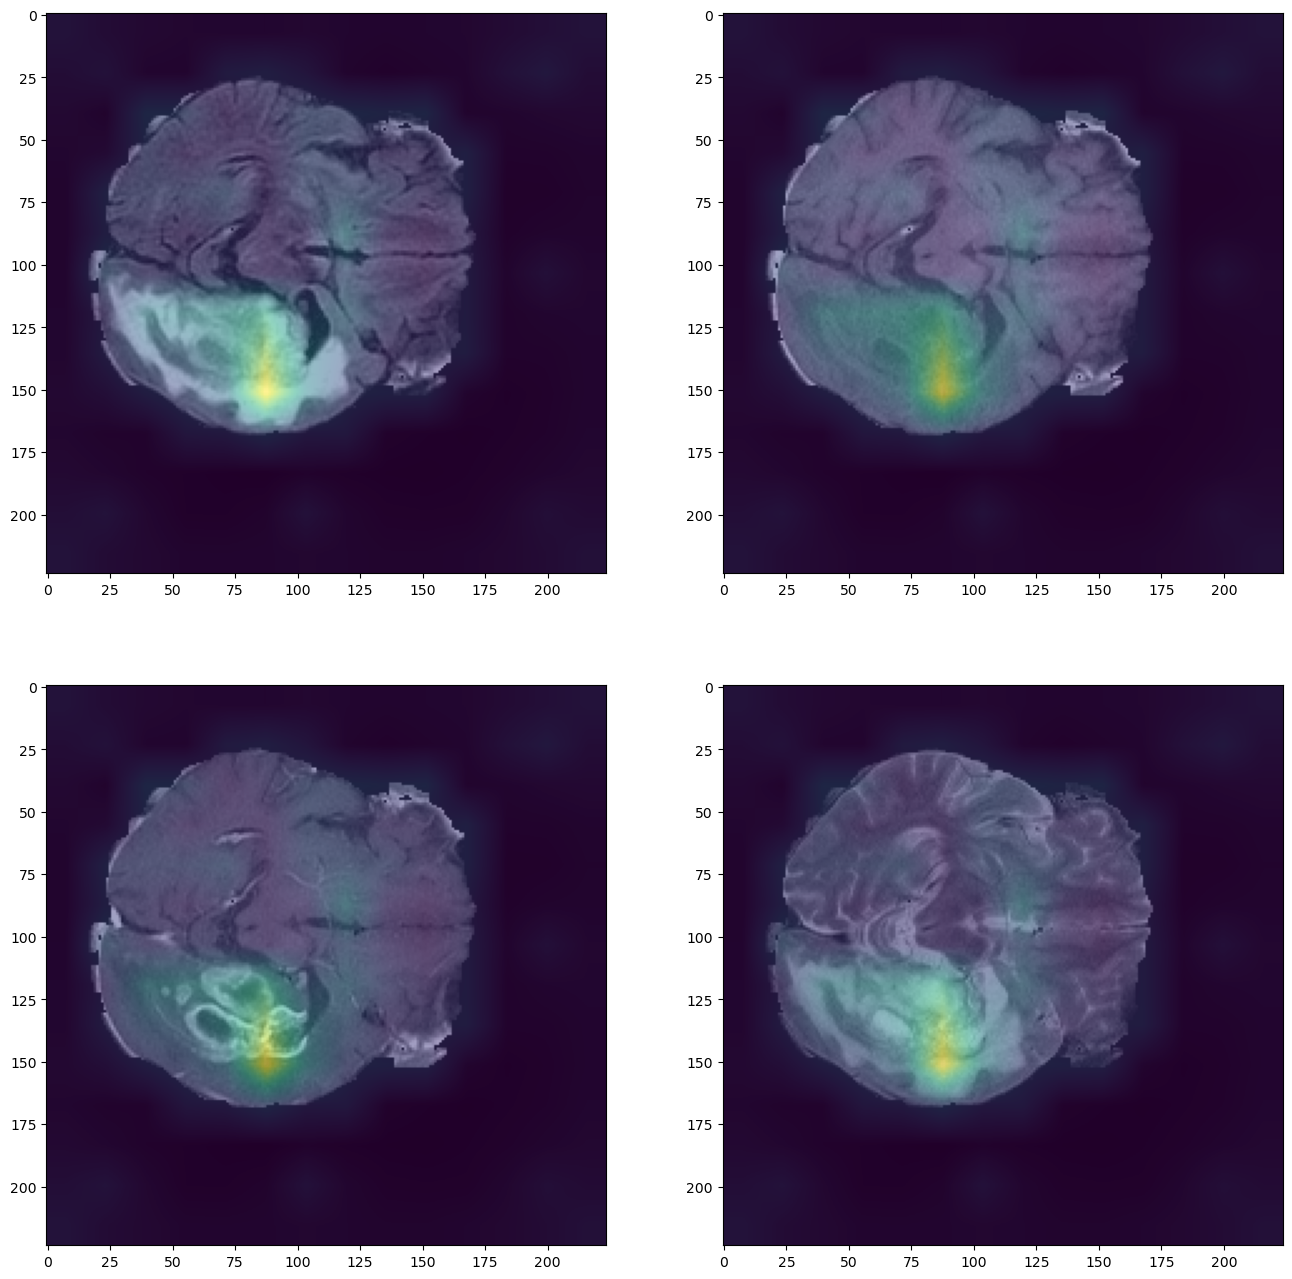

In [12]:
plt.figure(figsize=(16,16))
for i in range (len(target_image)):
    plt.subplot(2,2,i+1)
    imshow_vit(target_image[i,:,:])
    plt.imshow(mask, alpha=0.5)

In [13]:
predicted_pd = pd.read_csv('./data/for_attentionmap.csv')

## Wild type predicted Wild type

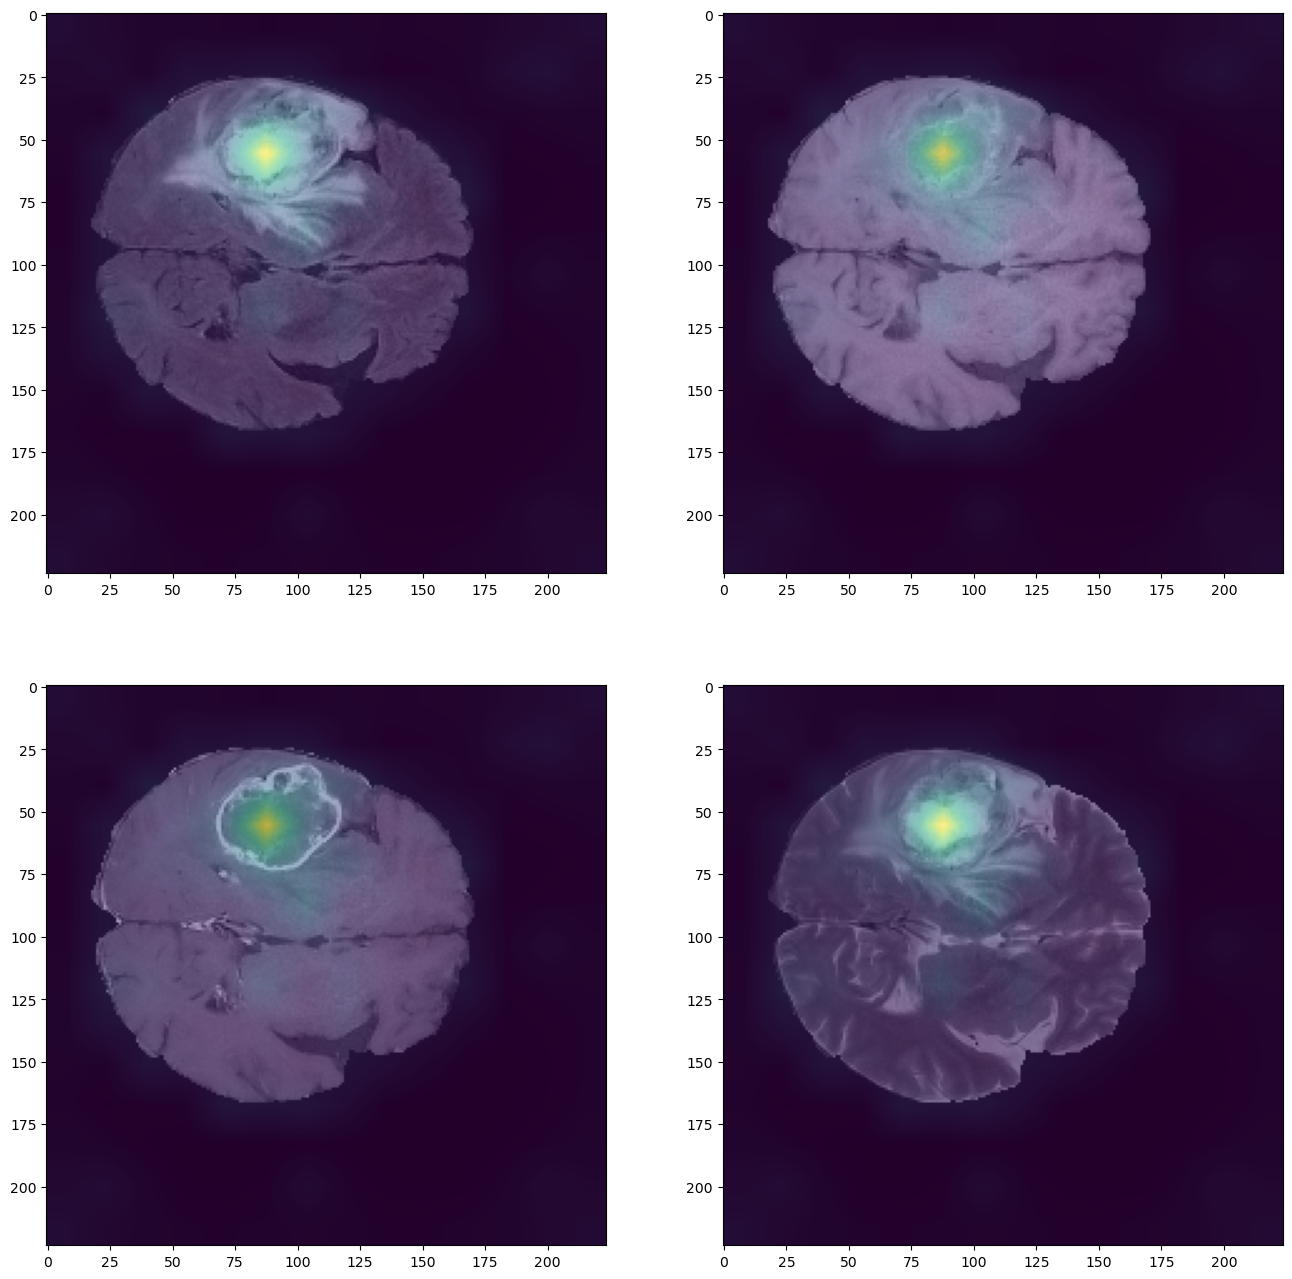

In [17]:
target_image = s_test[1][0]
mask = get_vit_small_patch16_22_attention_mask(timm_model,target_image)
plt.figure(figsize=(16,16))
for i in range (len(target_image)):
    plt.subplot(2,2,i+1)
    imshow_vit(target_image[i,:,:])
    plt.imshow(mask, alpha=0.5)

## IDH mutation predicted IDH mutation

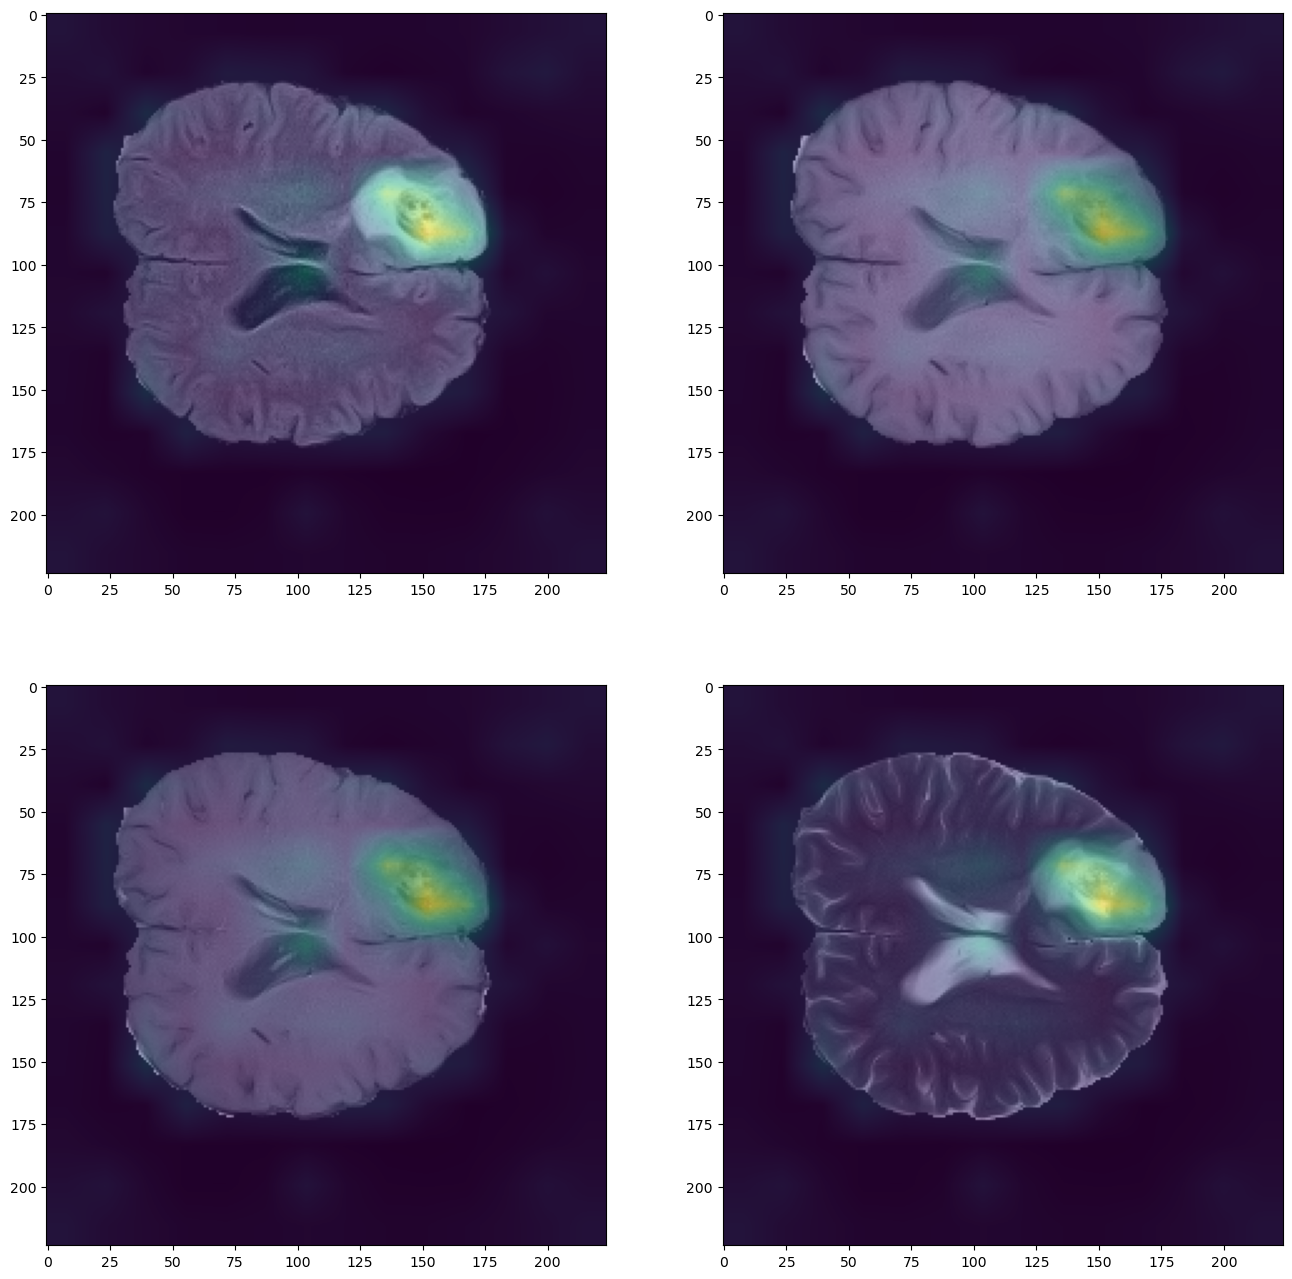

In [19]:
target_image = s_test[6][0]
mask = get_vit_small_patch16_22_attention_mask(timm_model,target_image)
plt.figure(figsize=(16,16))
for i in range (len(target_image)):
    plt.subplot(2,2,i+1)
    imshow_vit(target_image[i,:,:])
    plt.imshow(mask, alpha=0.5)

## Wild type predicted IDH mutation

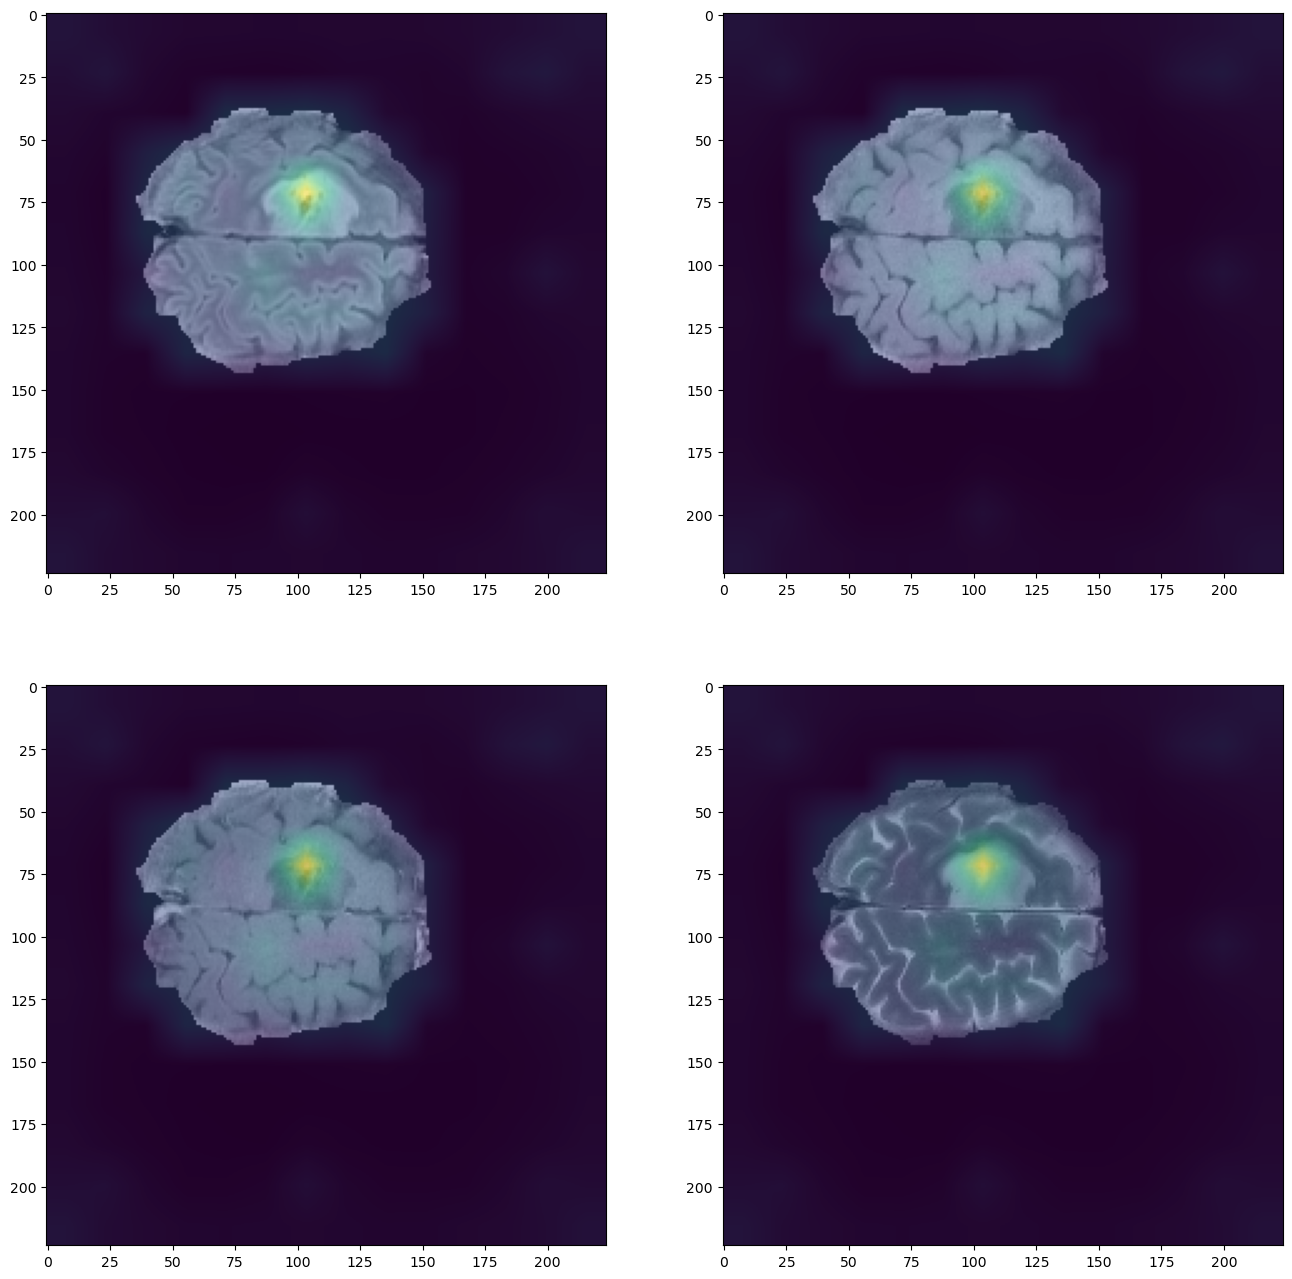

In [21]:
target_image = s_test[11][0]
mask = get_vit_small_patch16_22_attention_mask(timm_model,target_image)
plt.figure(figsize=(16,16))
for i in range (len(target_image)):
    plt.subplot(2,2,i+1)
    imshow_vit(target_image[i,:,:])
    plt.imshow(mask, alpha=0.5)

## IDH mutation predicted Wild type

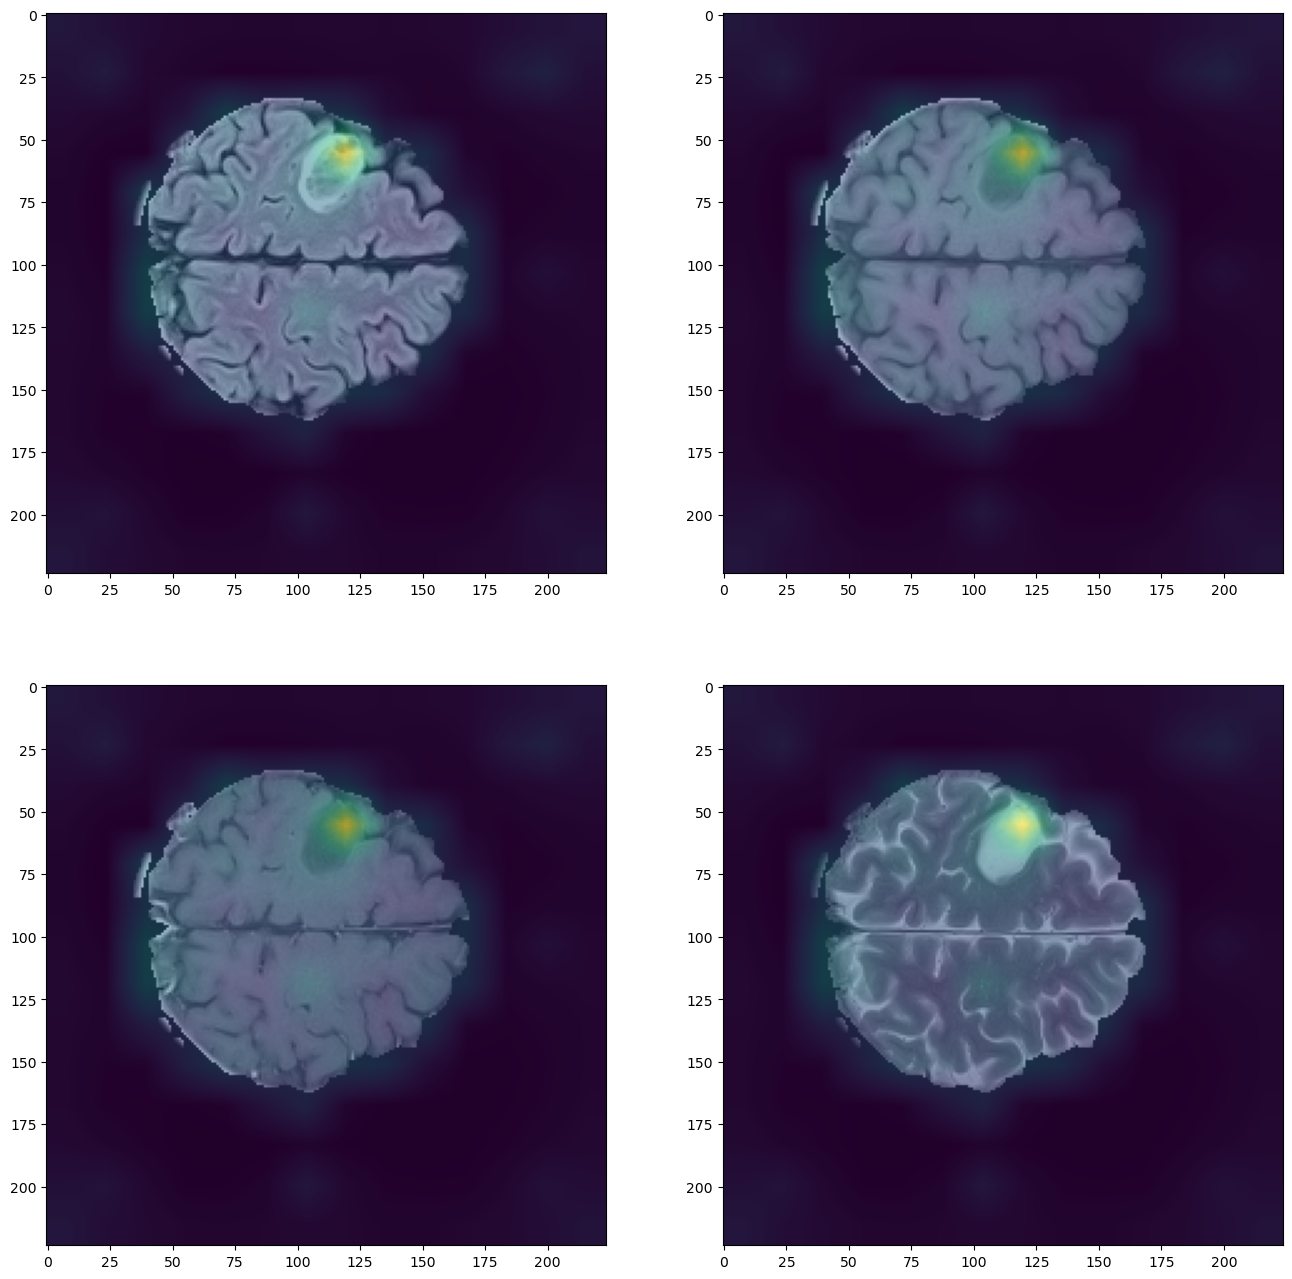

In [23]:
target_image = s_test[265][0]
mask = get_vit_small_patch16_22_attention_mask(timm_model,target_image)
plt.figure(figsize=(16,16))
for i in range (len(target_image)):
    plt.subplot(2,2,i+1)
    imshow_vit(target_image[i,:,:])
    plt.imshow(mask, alpha=0.5)